In [1]:
# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy import stats
from scipy.stats import randint, uniform

pd.options.display.float_format = '{:.2f}'.format

## IMPORT & EXPLORE

#### FUNCTIONS

In [2]:
def regression_report(dependent_test, 
                      estimator, 
                      independent_test,
                      predictions_plot=True):
    """ 
    This function calculates and prints basic performance metrics for regression evaluation.
    Additionally, it plots predicted vs actual values if `predictions_plot` is True.

    Parameters:
        dependent_test (array-like): Ground truth target values (y_test).
        estimator (model): Trained regression model.
        independent_test (array-like): Test input data (X_test).
        predictions_plot (bool): Whether to plot predicted vs actual values. Default is True.
    """
    
    # Calculate predictions
    predictions = estimator.predict(independent_test)
    
    # Performance Metrics
    print(f'R2 : {metrics.r2_score(dependent_test, predictions)}')
    print(f'MAE : {metrics.mean_absolute_error(dependent_test, predictions)}')
    print(f'MSE : {metrics.mean_squared_error(dependent_test, predictions)}')
    print(f'RMSE : {np.sqrt(metrics.mean_squared_error(dependent_test, predictions))}')
    
    # Plotting Predictions
    if predictions_plot:
        plt.figure(figsize=(12, 6))
        plt.scatter(dependent_test, predictions, alpha=0.6, edgecolor='k', label='Predictions')
        plt.plot([dependent_test.min(), dependent_test.max()],
                 [dependent_test.min(), dependent_test.max()],
                 color='red', linestyle='--', label='Ideal Fit')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title('Actual vs Predicted Values')
        plt.legend()
        plt.grid(alpha=0.3)

#### DATA

In [3]:
krisha_almaty_rental = pd.read_csv(r"C:\Users\User\Desktop\DATA SCIENCE\Github\krisha_bot\data\original_source\krisha_almaty_rental.csv.gz")

# add more data 

krisha_almaty_rental_ext = pd.read_csv(r"C:\Users\User\Downloads\almaty_apartments_clustered.csv")


In [4]:
clustering_features = ['floor', 'total_floors', 'area_sqm', 'rooms', 'price',
                       'full_address_code', 'furniture_code', 'parking_code', 'security_code',
                       'bathroom_code']

## CLEAN & PREPARE

In [5]:
krisha_almaty_rental_ext = pd.concat( [krisha_almaty_rental_ext,krisha_almaty_rental] )
krisha_almaty_rental_ext = krisha_almaty_rental_ext.drop_duplicates()

In [6]:
krisha_almaty_rental_ext_features = krisha_almaty_rental_ext[['floor', 'total_floors', 'area_sqm', 
                                                              'rooms', 'bathroom_code','price']]


In [7]:
krisha_almaty_rental_ext_features_independent = krisha_almaty_rental_ext_features.drop(columns = ['price'])

krisha_almaty_rental_ext_features_dependent = krisha_almaty_rental_ext_features['price']


In [101]:
from sklearn.model_selection import train_test_split

krisha_almaty_rental_ext_features_independent_train , krisha_almaty_rental_ext_features_independent_test ,krisha_almaty_rental_ext_features_dependent_train , krisha_almaty_rental_ext_features_dependent_test = train_test_split(
    krisha_almaty_rental_ext_features_independent,
    krisha_almaty_rental_ext_features_dependent,
    train_size = 0.95 ,
    random_state = 42
) 

In [121]:
print(f'INDEPENDENT SUBSETS SHAPES (TRAIN - TEST) : {krisha_almaty_rental_ext_features_independent_train.shape,krisha_almaty_rental_ext_features_independent_test.shape}')

INDEPENDENT SUBSETS SHAPES (TRAIN - TEST) : ((20150, 5), (1179, 5))


## MODEL BUILD

In [122]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import HistGradientBoostingRegressor

In [143]:
hgb = HistGradientBoostingRegressor(max_iter = 500)

In [144]:
hgb_param_distributions = {'learning_rate': [0.01, 0.05, 0.1, 0.2],
                           'max_leaf_nodes': [15, 31, 63, 127],
                           'min_samples_leaf': [10, 20, 50, 100],
                           'max_depth': [None, 10, 20, 30],
                           'l2_regularization': [0.0, 0.1, 0.5, 1.0],
                           'early_stopping': [True, False]}

In [145]:
krisha_almaty_rental_hgb_random_search_cv = RandomizedSearchCV( estimator = hgb,
                                                                param_distributions = hgb_param_distributions,
                                                                cv = 5,
                                                                n_iter = 100,
                                                                scoring = 'neg_mean_absolute_error',
                                                                verbose = 1 )

In [146]:
krisha_almaty_rental_hgb_random_search_cv.fit(krisha_almaty_rental_ext_features_independent_train,
                                              krisha_almaty_rental_ext_features_dependent_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=HistGradientBoostingRegressor(max_iter=500),
                   n_iter=100,
                   param_distributions={'early_stopping': [True, False],
                                        'l2_regularization': [0.0, 0.1, 0.5,
                                                              1.0],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [None, 10, 20, 30],
                                        'max_leaf_nodes': [15, 31, 63, 127],
                                        'min_samples_leaf': [10, 20, 50, 100]},
                   scoring='neg_mean_absolute_error', verbose=1)

In [147]:
krisha_almaty_rental_hgb_random_search_cv.best_params_

{'min_samples_leaf': 10,
 'max_leaf_nodes': 63,
 'max_depth': 20,
 'learning_rate': 0.2,
 'l2_regularization': 0.0,
 'early_stopping': False}

In [148]:
hgb500 = HistGradientBoostingRegressor( max_iter = 500,
                                        min_samples_leaf = 10,
                                        max_leaf_nodes = 63,
                                        max_depth = 20,
                                        learning_rate = 0.2,
                                        l2_regularization = 0,
                                        early_stopping = False )

In [150]:
from sklearn.model_selection import cross_val_score

hgb500_crossval_scores = cross_val_score( X = krisha_almaty_rental_ext_features_independent_train,
                                          y = krisha_almaty_rental_ext_features_dependent_train,
                                          cv = 5 ,
                                          scoring = 'neg_mean_absolute_error',
                                          estimator = hgb500 )

print(np.mean(hgb500_crossval_scores))


-65681.41891848539


In [152]:
hgb750 = HistGradientBoostingRegressor( max_iter = 750,
                                        min_samples_leaf = 10,
                                        max_leaf_nodes = 63,
                                        max_depth = 20,
                                        learning_rate = 0.2,
                                        l2_regularization = 0,
                                        early_stopping = False )

hgb750_crossval_scores = cross_val_score( X = krisha_almaty_rental_ext_features_independent_train,
                                          y = krisha_almaty_rental_ext_features_dependent_train,
                                          cv = 5 ,
                                          scoring = 'neg_mean_absolute_error',
                                          estimator = hgb750 )

print(np.mean(hgb750_crossval_scores))


-65867.91968614415


In [155]:
krisha_almaty_rental_hgb = HistGradientBoostingRegressor( max_iter = 500,
                                                          min_samples_leaf = 10,
                                                          max_leaf_nodes = 63,
                                                          max_depth = 20,
                                                          learning_rate = 0.2,
                                                          l2_regularization = 0,
                                                          early_stopping = False )

krisha_almaty_rental_hgb.fit(krisha_almaty_rental_ext_features_independent_train,
                             krisha_almaty_rental_ext_features_dependent_train)


HistGradientBoostingRegressor(early_stopping=False, l2_regularization=0,
                              learning_rate=0.2, max_depth=20, max_iter=500,
                              max_leaf_nodes=63, min_samples_leaf=10)

In [117]:
krisha_almaty_rental_sequential_nn.compile( optimizer = optimizers.Adam(),
                                            loss = losses.MeanSquaredError(),
                                            metrics = ['mae'] )

krisha_almaty_rental_sequential_nn_early_stop = callbacks.EarlyStopping( monitor = 'val_loss',
                                                                         patience = 75,
                                                                         restore_best_weights = True )


### EVALUATE

R2 : 0.7464757023769217
MAE : 62797.16007094279
MSE : 17969475120.54231
RMSE : 134050.2708708278


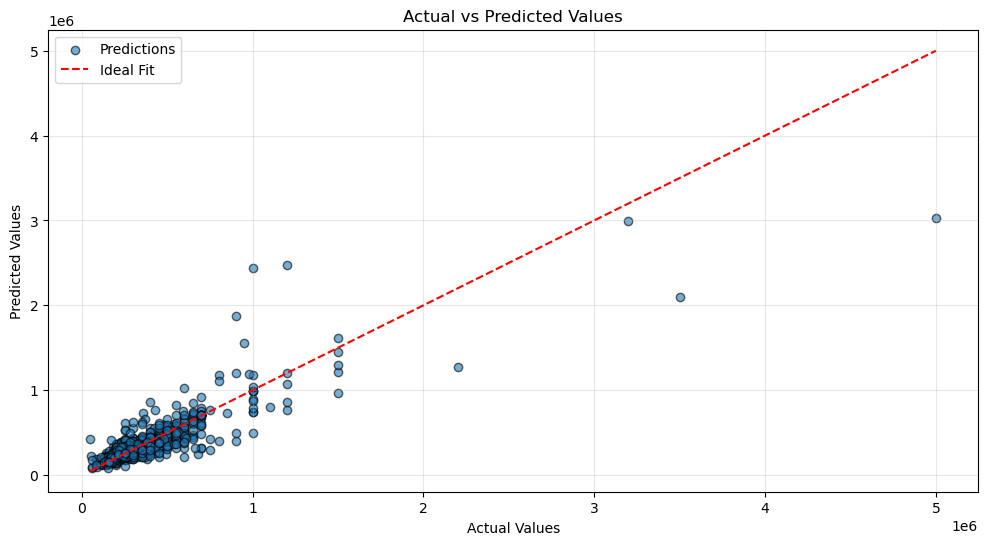

In [156]:
regression_report( independent_test = krisha_almaty_rental_ext_features_independent_test,
                   dependent_test = krisha_almaty_rental_ext_features_dependent_test,
                   estimator = krisha_almaty_rental_hgb,
                   predictions_plot = True)

## SAVE

In [159]:
from joblib import dump, load

In [158]:
dump( krisha_almaty_rental_hgb, "krisha_almaty_rental_hgb500.joblib" )

['krisha_almaty_rental_hgb500.joblib']

In [160]:
#### TEST LOAD


krisha_almaty_rental_hgb = load(r"C:\Users\User\Desktop\DATA SCIENCE\Github\krisha_bot\models\krisha_almaty_rental_hgb500.joblib")

In [161]:
krisha_almaty_rental_hgb

HistGradientBoostingRegressor(early_stopping=False, l2_regularization=0,
                              learning_rate=0.2, max_depth=20, max_iter=500,
                              max_leaf_nodes=63, min_samples_leaf=10)

In [162]:
test_dict = { 'floor' : [3], 
              'total_floors': [5], 
              'area_sqm' : [55], 
              'rooms' : [3], 
              'bathroom_code' : [0] } 

test_dict2 = { 'floor' : [10], 
              'total_floors': [12], 
              'area_sqm' : [30], 
              'rooms' : [1], 
              'bathroom_code' : [1] } 

In [163]:
krisha_almaty_rental_hgb.predict(pd.DataFrame(test_dict))

array([314890.25850033])

In [164]:
krisha_almaty_rental_hgb.predict(pd.DataFrame(test_dict2))

array([215134.86779328])